> You can open this notebook in Colab by clicking the Colab icon. Colab provides GPU for free. You can also run this notebook locally by installing the dependencies listed in `requirements.txt`.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/osbm/unet_explainer/blob/main/tutorial-part1.ipynb)

In [ ]:
!pip install git+https://github.com/osbm/unet_explainer.git

In [1]:
from unet_pytorch import ProstateDataset, print_model_info, predict, set_seed
from unet_pytorch import plot_predictions

from torch.utils.data import DataLoader
import torch
from torch import nn
from monai.networks.nets import UNet
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os

In [ ]:
if not os.path.exists('data'):
    !wget -q https://huggingface.co/datasets/osbm/unet-explainer-data/resolve/main/data.zip
    !unzip -q data.zip

In [3]:
!wget -q https://huggingface.co/datasets/osbm/unet-explainer-data/resolve/main/best_model.pth

--2023-10-11 11:19:59--  https://huggingface.co/datasets/osbm/unet-explainer-data/resolve/main/best_model.pth
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving huggingface.co (huggingface.co)... 2600:9000:2017:1800:17:b174:6d00:93a1, 2600:9000:2017:1c00:17:b174:6d00:93a1, 2600:9000:2017:ca00:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:2017:1800:17:b174:6d00:93a1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/9c/63/9c6363119498925ea4fadbe8b0256ce994bae4419cdaa32e07c1c423456bb35b/ad07cefd61f55da4841d091c73e7bc9960dd2e0c27cb65467224ea825a6dc233?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27best_model.pth%3B+filename%3D%22best_model.pth%22%3B&Expires=1697271607&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5NzI3MTYwN319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy85Yy82My85YzYzNjMxMTk0

In [2]:
set_seed(42)

Seed set to 42.


In [3]:
image_size = 256
valid_transforms = A.Compose([
    A.Resize(height=image_size, width=image_size),
    ToTensorV2(),
])
test_ds = ProstateDataset(folder='data/test', transform=valid_transforms)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

In [4]:
model = UNet(
    spatial_dims=2, # 2d image
    in_channels=1,  # we only used  T2 weighed MRI images
    out_channels=3, # 3 labels
    channels=[16, 32, 64, 128, 256, 512],
    strides=(2, 2, 2, 2, 2), # CNN strides
    num_res_units=4, # residual connections
    dropout=0.15, # dropout rate
)
print_model_info(model)

Total number of trainable parameters: 12,809,864 (48.87MB)


In [5]:
model.load_state_dict(torch.load('best_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

100%|██████████| 22/22 [00:08<00:00,  2.67it/s]


Dice score: tensor([0.5231])
IoU score: 0.7067916393280029


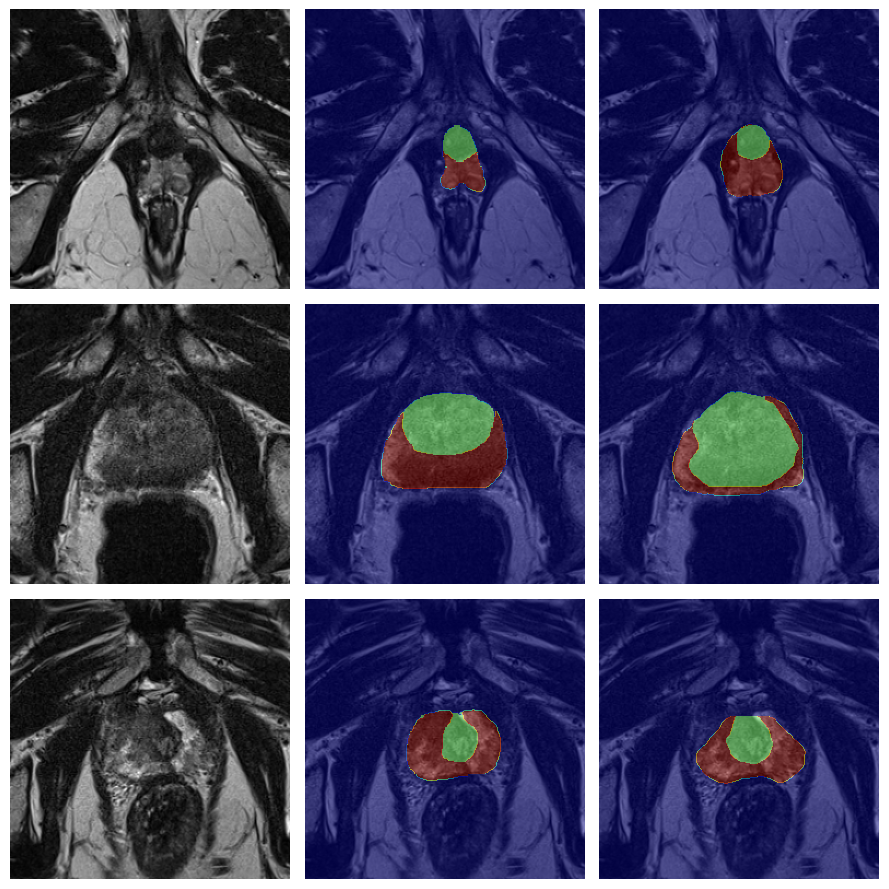

In [6]:
x, y, y_hat = predict(model, test_loader=test_loader, device=device, final_activation="softmax")

In [ ]:
plot_predictions(x, y, y_hat, num_examples_to_plot=5)